# Analysis Notebook

In [41]:
import time
import utils
import requests
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set_theme()

## 1) Data Sampling and Collection

Please Add short description of process.

In [42]:
# By Ned Antell

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path

def fetch_and_cache_gdrive(gdrive_id, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        download_file_from_google_drive(gdrive_id, file_path)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path



# https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [43]:
# By Ned Antell
#Pull data from google drive

#bioCON plant diversity
#utils.fetch_and_cache_gdrive('1WIIljYUz3B45K9DOA1M3cfGOedtgxLFL', 'bioCON_plant_diversity.txt', data_dir = '')

#pollinators 1
fetch_and_cache_gdrive('1JCynlMV0Um07MUa3E0qSqdDYOGfy9Eyr', 'plant_pollinator_diversity_set1.csv', data_dir = 'data/')

#pollinators 2
fetch_and_cache_gdrive('1IjzzaYep_BXIzMVjIBmh8AiXbydwmYk_', 'plant_pollinator_diversity_set2.csv', data_dir = 'data/')

Using cached version that was downloaded (UTC): Mon Nov 21 15:00:38 2022
Using cached version that was downloaded (UTC): Mon Nov 21 15:00:39 2022


WindowsPath('data/plant_pollinator_diversity_set2.csv')

In [44]:
file1 = 'data/plant_pollinator_diversity_set1.csv'
file2 = 'data/plant_pollinator_diversity_set2.csv'

In [45]:
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df2.head()

,DBCODE,ENTITY,COMPLEX,MEADOW,PLOT_ID,YEAR,SAMPLEDATE,WATCH,OBSERVER,PLOT,FLW_STATUS,PLTSP_CODE,PLTSP_NAME,NO_STALK,NO_FLWS,QC_NOTES
0,SA026,2,Bunchgrass,BD,BGD01,2011,2011-07-20,1.0,ND,1,NaN,NaN,NaN,NaN,NaN,NaN
1,SA026,2,Bunchgrass,BD,BGD01,2011,2011-07-25,2.0,Andy,1,FLW,ACHIMILL,Achillea millefolium,4.0,36.0,NaN
2,SA026,2,Bunchgrass,BD,BGD01,2011,2011-07-25,2.0,Andy,1,FLW,ERIGFOLI,Erigeron foliosus,14.0,1.0,NaN
3,SA026,2,Bunchgrass,BD,BGD01,2011,2011-07-25,2.0,Andy,1,FLW,VICIAMER,Vicia americana,3.0,2.3,NaN
4,SA026,2,Bunchgrass,BD,BGD01,2011,2011-08-02,3.0,"Andy, Tim",1,FLW,ACHIMILL,Achillea millefolium,2.0,26.0,NaN


In [46]:
df1.head()

,DBCODE,ENTITY,COMPLEX,MEADOW,PLOT_ID,YEAR,SAMPLEDATE,WATCH,OBSERVER,PLOT,...,PPI_STATUS,NO_INT,PLTSP_CODE,PLTSP_NAME,VISSP_CODE,VISSP_NAME,VISSP_TYPE,REF_NO,VISSP_NO,QC_NOTES
0,SA026,1,Bunchgrass,BD,BGD01,2011,2011-07-24,2.0,NaN,1,...,1,2.0,ACHIMILL,Achillea millefolium,EPICPUNC,Epicauta puncticollis,predaceous beetle,NaN,1,NaN
1,SA026,1,Bunchgrass,BD,BGD01,2011,2011-07-24,2.0,NaN,1,...,1,1.0,ACHIMILL,Achillea millefolium,EVYLS5M,Evylaeus sp 5M,halictine bee,NaN,1,NaN
2,SA026,1,Bunchgrass,BD,BGD01,2011,2011-07-24,2.0,NaN,1,...,1,2.0,ERIGFOLI,Erigeron foliosus,MUSCGEN3,Muscoid genus 3,herbivorous muscoid fly,NaN,1,NaN
3,SA026,1,Bunchgrass,BD,BGD01,2011,2011-07-24,2.0,NaN,1,...,1,2.0,ERIGFOLI,Erigeron foliosus,MUSCGEN3,Muscoid genus 3,herbivorous muscoid fly,NaN,2,NaN
4,SA026,1,Bunchgrass,BD,BGD01,2011,2011-07-24,2.0,NaN,1,...,1,2.0,ERIGFOLI,Erigeron foliosus,TRICORNA,Trichodes ornatus,bee-parasitic beetle,NaN,1,NaN


## 2) Data Cleaning

Please Add short description of process.

### Dropping unnecessary columns

In [47]:
# Drop unnecessary/redundant columns for our data analysis

def drop_columns(dataframe, todrop):
    # dataframe: Pandas Dataset to drop columns from
    # todrop: list of columns to drop
    df = dataframe.drop(todrop, axis=1)
    return df

In [48]:
drop_cols_1 = ['DBCODE', 'ENTITY', 'COMPLEX', 'MEADOW', 'START_TIME', 'END_TIME', 'MINUTE', 'OBSERVER', 'QC_NOTES']
drop_cols_2 = ['DBCODE', 'ENTITY', 'COMPLEX', 'MEADOW', 'YEAR', 'OBSERVER', 'QC_NOTES']

df1 = drop_columns(df1, drop_cols_1)
df2 = drop_columns(df2, drop_cols_2)
df1.head()

,PLOT_ID,YEAR,SAMPLEDATE,WATCH,PLOT,CLOUDS,WIND,TEMP,PPI_STATUS,NO_INT,PLTSP_CODE,PLTSP_NAME,VISSP_CODE,VISSP_NAME,VISSP_TYPE,REF_NO,VISSP_NO
0,BGD01,2011,2011-07-24,2.0,1,S,ST,NaN,1,2.0,ACHIMILL,Achillea millefolium,EPICPUNC,Epicauta puncticollis,predaceous beetle,NaN,1
1,BGD01,2011,2011-07-24,2.0,1,S,ST,NaN,1,1.0,ACHIMILL,Achillea millefolium,EVYLS5M,Evylaeus sp 5M,halictine bee,NaN,1
2,BGD01,2011,2011-07-24,2.0,1,S,ST,NaN,1,2.0,ERIGFOLI,Erigeron foliosus,MUSCGEN3,Muscoid genus 3,herbivorous muscoid fly,NaN,1
3,BGD01,2011,2011-07-24,2.0,1,S,ST,NaN,1,2.0,ERIGFOLI,Erigeron foliosus,MUSCGEN3,Muscoid genus 3,herbivorous muscoid fly,NaN,2
4,BGD01,2011,2011-07-24,2.0,1,S,ST,NaN,1,2.0,ERIGFOLI,Erigeron foliosus,TRICORNA,Trichodes ornatus,bee-parasitic beetle,NaN,1


### Merging Datasets

In [49]:
# Merge datasets (union on PLOT_ID)
dff = df1.merge(df2, on=['PLOT_ID', 'SAMPLEDATE', 'PLTSP_CODE', 'PLTSP_NAME', 'PLOT', 'WATCH'], how='outer')
dff.head()

,PLOT_ID,YEAR,SAMPLEDATE,WATCH,PLOT,CLOUDS,WIND,TEMP,PPI_STATUS,NO_INT,PLTSP_CODE,PLTSP_NAME,VISSP_CODE,VISSP_NAME,VISSP_TYPE,REF_NO,VISSP_NO,FLW_STATUS,NO_STALK,NO_FLWS
0,BGD01,2011.0,2011-07-24,2.0,1,S,ST,NaN,1.0,2.0,ACHIMILL,Achillea millefolium,EPICPUNC,Epicauta puncticollis,predaceous beetle,NaN,1.0,NaN,NaN,NaN
1,BGD01,2011.0,2011-07-24,2.0,1,S,ST,NaN,1.0,1.0,ACHIMILL,Achillea millefolium,EVYLS5M,Evylaeus sp 5M,halictine bee,NaN,1.0,NaN,NaN,NaN
2,BGD01,2011.0,2011-07-24,2.0,1,S,ST,NaN,1.0,1.0,ACHIMILL,Achillea millefolium,ANTHASP1,Anthaxia sp 1,herbivorous beetle,NaN,1.0,NaN,NaN,NaN
3,BGD01,2011.0,2011-07-24,2.0,1,S,ST,NaN,1.0,1.0,ACHIMILL,Achillea millefolium,ERISHIRT,Eristalis hirtus,decomposer hover-fly,NaN,1.0,NaN,NaN,NaN
4,BGD01,2011.0,2011-07-24,2.0,1,S,ST,NaN,1.0,2.0,ERIGFOLI,Erigeron foliosus,MUSCGEN3,Muscoid genus 3,herbivorous muscoid fly,NaN,1.0,NaN,NaN,NaN


### Cleaning NaNs

In [50]:
# Drop NaNs
dff = dff.dropna(subset=['TEMP', 'FLW_STATUS', 'NO_STALK', 'NO_FLWS'])
dff.sample(15)

,PLOT_ID,YEAR,SAMPLEDATE,WATCH,PLOT,CLOUDS,WIND,TEMP,PPI_STATUS,NO_INT,PLTSP_CODE,PLTSP_NAME,VISSP_CODE,VISSP_NAME,VISSP_TYPE,REF_NO,VISSP_NO,FLW_STATUS,NO_STALK,NO_FLWS
36809,FNE02,2017.0,2017-07-28,5.0,2,S,ST,22.0,1.0,1.0,ERIOLANA,Eriophyllum lanatum,EPICPUNC,Epicauta puncticollis,NaN,NaN,3.0,FLW,194.0,3.2
59246,LOS07,2018.0,2018-07-16,2.0,7,S,BR,34.0,1.0,5.0,ERIGFOLI,Erigeron foliosus,BOMBBIFA,Bombus bifarius,NaN,NaN,2.0,FLW,120.0,1.0
72234,RP206,2018.0,2018-07-19,3.0,6,S,BR,22.0,1.0,2.0,CASTHISP,Castilleja hispida,DIALRUBR,Dialictus rubriventris,NaN,NaN,1.0,FLW,3.0,2.0
19322,CPR08,2018.0,2018-07-05,2.0,8,S,ST,21.0,1.0,4.0,PENSCARD,Penstemon cardwellii,BOMBMIXT,Bombus mixtus,NaN,NaN,10.0,FLW,76.0,4.3
68736,RP110,2017.0,2017-06-30,2.0,10,S,ST,23.0,1.0,3.0,LATHNEVA,Lathyrus nevadensis,ANDRPECA,Andrena pertristis carliniformis,NaN,NaN,1.0,FLW,1.0,1.0
73214,RP209,2015.0,2015-06-30,2.0,9,S,ST,28.0,1.0,12.0,ERIOLANA,Eriophyllum lanatum,APISMELL,Apis mellifera,social bee,field id,2.0,FLW,29.0,6.0
39672,FNE07,2018.0,2018-07-03,2.0,7,S,ST,20.0,1.0,3.0,COLLPARV,Collinsia parviflora,BOMBMIXT,Bombus mixtus,NaN,NaN,1.0,FLW,117.0,2.0
21902,CPS06,2018.0,2018-07-17,3.0,6,S,BR,24.0,1.0,4.0,HYPEPERF,Hypericum perforatum,BOMBMIXT,Bombus mixtus,NaN,NaN,1.0,FLW,35.0,1.9
59018,LOS07,2015.0,2015-07-01,2.0,7,SH,ST,32.0,1.0,6.0,GILICAPI,Gilia capitata,APISMELL,Apis mellifera,social bee,field id,1.0,FLW,45.0,1.0
64067,RP103,2017.0,2017-06-26,1.0,3,S,BR,24.0,1.0,1.0,CERAARVE,Cerastium arvense,MUSCGEN3,Muscoid genus 3,NaN,NaN,1.0,FLW,1.0,1.0


In [51]:
dff.describe()

,YEAR,WATCH,PLOT,TEMP,PPI_STATUS,NO_INT,VISSP_NO,NO_STALK,NO_FLWS
count,24896.000000,24896.000000,24896.000000,24896.000000,24896.0,24883.000000,24896.000000,24896.000000,24896.000000
mean,2016.967103,2.829531,5.373353,22.853109,1.0,3.230278,1.762010,50.104354,8.037982
std,1.158845,1.278187,2.899112,4.419978,0.0,4.027019,1.794089,59.315180,18.698536
min,2013.000000,1.000000,1.000000,10.000000,1.0,1.000000,1.000000,1.000000,0.000000
25%,2016.000000,2.000000,3.000000,20.000000,1.0,1.000000,1.000000,9.000000,1.500000
50%,2017.000000,3.000000,5.000000,23.000000,1.0,2.000000,1.000000,29.000000,2.600000
75%,2018.000000,4.000000,8.000000,26.000000,1.0,4.000000,2.000000,75.000000,7.000000
max,2018.000000,7.000000,10.000000,37.000000,1.0,200.000000,26.000000,781.000000,380.000000


In [52]:
dff['NO_INT'] = dff['NO_INT'].fillna(0)

## 3) Exploratory Data Analysis

Please Add short description of process.

Preliminary Visualization

In [53]:
dff18 = dff[dff['YEAR'] == 2018]
px.scatter(dff18, x='TEMP', y='NO_STALK', symbol='CLOUDS', color='WIND', title='No. of Stalks vs Temperature in 2018')

In [54]:
px.scatter(dff18, x='TEMP', y='NO_FLWS', symbol='CLOUDS', color='WIND', title='No. of Flowers vs Temperature in 2018')

In [55]:
px.scatter(dff18, x='TEMP', y='NO_INT', symbol='CLOUDS', color='WIND', title='No. of Interactions vs Temperature in 2018')

In [56]:
px.scatter(dff18, x='NO_FLWS', y='NO_INT', symbol='CLOUDS', color='WIND', title='No. of Interactions vs Temperature in 2018')

In [57]:
# Encoding values to numbers for easier analysis

dff_encoded = dff.replace({
    'WIND': {
        'BR': 1,
        'ST': 0
    },  
    'CLOUDS': {
        'SH': 0,
        'PC': 1,
        'C':  2,
        'S':  3,
    },
    'FLW_STATUS': {
        'FLW': 1,
        'NOF': 0
    }
})

Pairwise Correlation

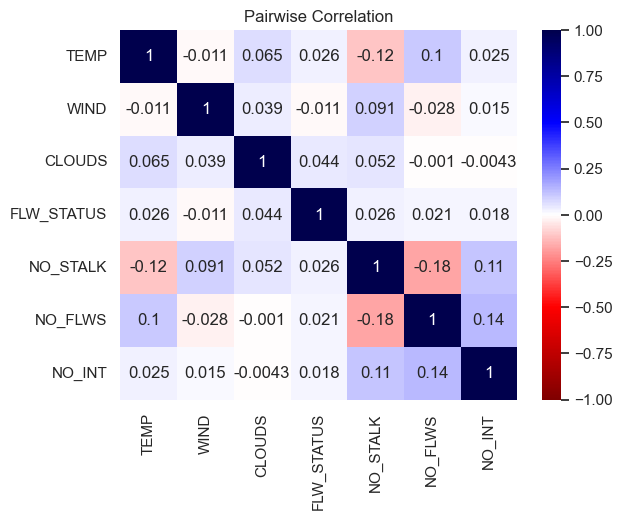

In [58]:
dff_corr = dff_encoded[['TEMP', 'WIND', 'CLOUDS', 'FLW_STATUS',  'NO_STALK', 'NO_FLWS', 'NO_INT']].corr()
sns.heatmap(data=dff_corr, annot=True, vmin=-1, vmax=1, cmap='seismic_r').set(title='Pairwise Correlation')
plt.show()

Heatmaps

In [59]:
dff_heat = dff[['NO_INT', 'PLTSP_NAME', 'VISSP_NAME']]

grouped_dff = dff_heat.groupby(['PLTSP_NAME', 'VISSP_NAME']).agg({'NO_INT': ['mean', 'min', 'max']})
grouped_dff.columns = ['int_mean', 'int_min', 'int_max']
grouped_dff = grouped_dff.reset_index()
grouped_dff

,PLTSP_NAME,VISSP_NAME,int_mean,int_min,int_max
0,Achillea millefolium,Acridid sp 1,1.000000,1.0,1.0
1,Achillea millefolium,Ammophila sp 1,1.000000,1.0,1.0
2,Achillea millefolium,Anaspis rufa,1.857143,1.0,2.0
3,Achillea millefolium,Anastrangalia laetifica,1.000000,1.0,1.0
4,Achillea millefolium,Anthrenus sp 17-1,1.000000,1.0,1.0
...,...,...,...,...,...
2103,Zigadenus venenosus,Syrphid sp B,7.200000,5.0,10.0
2104,Zigadenus venenosus,Syrphidae,5.500000,1.0,10.0
2105,Zigadenus venenosus,Syrphus vitripennis,1.000000,1.0,1.0
2106,Zigadenus venenosus,Tapinoma sessile,1.000000,1.0,1.0


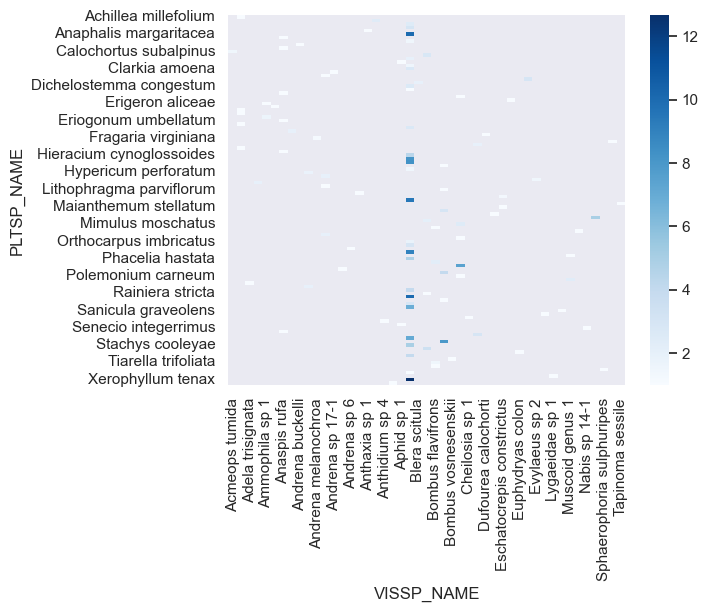

In [60]:
plant_subset = grouped_dff.drop_duplicates(subset='PLTSP_NAME')
plant_pivot = plant_subset.pivot('PLTSP_NAME', 'VISSP_NAME', 'int_mean')
sns.heatmap(plant_pivot, cmap='Blues');

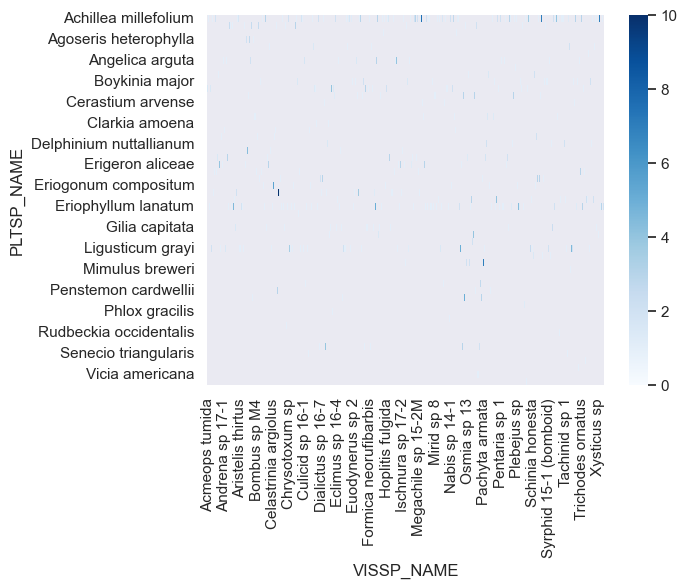

In [61]:
poll_subset = grouped_dff.drop_duplicates(subset='VISSP_NAME')
poll_pivot = poll_subset.pivot('PLTSP_NAME', 'VISSP_NAME', 'int_mean')
sns.heatmap(poll_pivot, cmap='Blues');

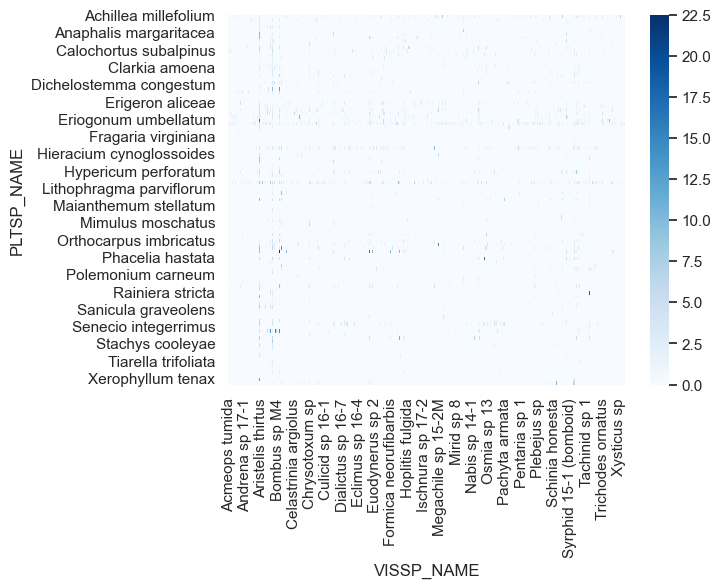

In [62]:
grouped_pivot = grouped_dff.pivot_table('int_mean','PLTSP_NAME','VISSP_NAME').fillna(0)
sns.heatmap(grouped_pivot, cmap='Blues');

Lots of Empty nodes. Overplotting, makes it hard to see any pattern. Let's limit to anything with >= 5 interactions instead and reproduce this.

In [63]:
dff_heat = dff_heat[dff_heat['NO_INT'] >= 15.0]

grouped_dff = dff_heat.groupby(['PLTSP_NAME', 'VISSP_NAME']).agg({'NO_INT': ['mean', 'min', 'max']})
grouped_dff.columns = ['int_mean', 'int_min', 'int_max']
grouped_dff = grouped_dff.reset_index()
grouped_dff.head()

,PLTSP_NAME,VISSP_NAME,int_mean,int_min,int_max
0,Achillea millefolium,Mordella atrata albosuturalis,15.000000,15.0,15.0
1,Angelica arguta,Apis mellifera,20.717391,15.0,33.0
2,Angelica arguta,Bombus bifarius,18.000000,16.0,19.0
3,Boykinia major,Apis mellifera,19.500000,15.0,30.0
4,Calochortus subalpinus,Apis mellifera,17.000000,15.0,19.0


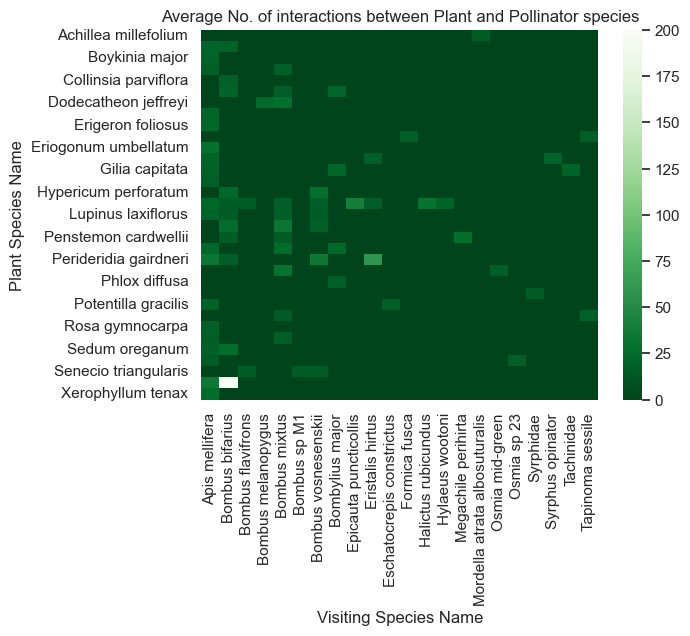

In [64]:
grouped_pivot = grouped_dff.pivot_table('int_mean','PLTSP_NAME','VISSP_NAME').fillna(0)
sns.heatmap(grouped_pivot, cmap='Greens_r')
plt.xlabel('Visiting Species Name')
plt.ylabel('Plant Species Name')
plt.title('Average No. of interactions between Plant and Pollinator species')

plt.show()

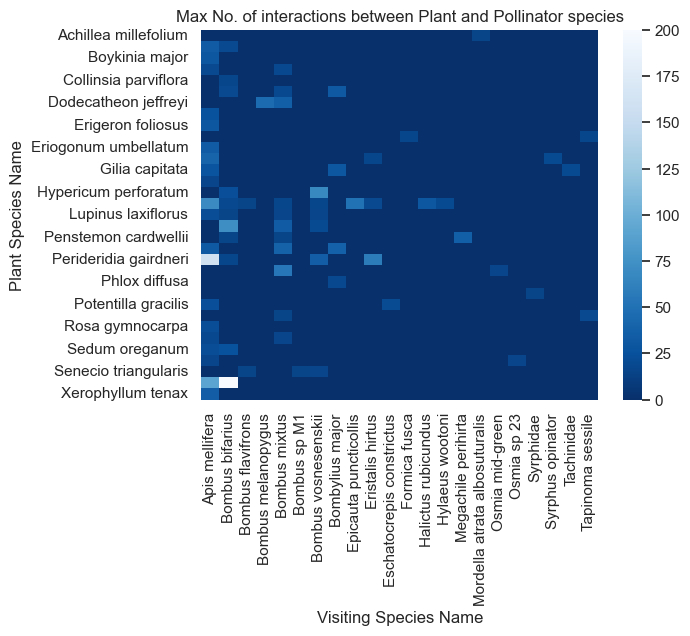

In [65]:
grouped_pivot = grouped_dff.pivot_table('int_max','PLTSP_NAME','VISSP_NAME').fillna(0)
sns.heatmap(grouped_pivot, cmap='Blues_r')
plt.xlabel('Visiting Species Name')
plt.ylabel('Plant Species Name')
plt.title('Max No. of interactions between Plant and Pollinator species')

plt.show()

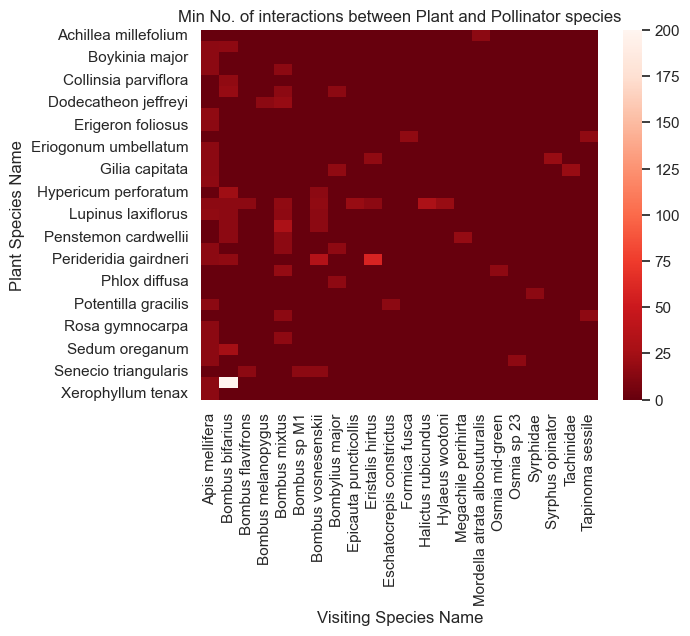

In [66]:
grouped_pivot = grouped_dff.pivot_table('int_min','PLTSP_NAME','VISSP_NAME').fillna(0)
sns.heatmap(grouped_pivot, cmap='Reds_r')
plt.xlabel('Visiting Species Name')
plt.ylabel('Plant Species Name')
plt.title('Min No. of interactions between Plant and Pollinator species')

plt.show()

## 3b) Feature Engineering

In [67]:
dff_encoded = pd.get_dummies(data=dff_encoded, columns=['PLTSP_NAME', 'VISSP_NAME'])
dff_encoded

,PLOT_ID,YEAR,SAMPLEDATE,WATCH,PLOT,CLOUDS,WIND,TEMP,PPI_STATUS,NO_INT,...,VISSP_NAME_Xylota sp 2,VISSP_NAME_Xylota sp 4,VISSP_NAME_Xysticus sp,VISSP_NAME_Zodion sp 1,VISSP_NAME_beetle sp 15-1,VISSP_NAME_parasitic wasp sp 15-1,VISSP_NAME_parasitic wasp sp 15-2,VISSP_NAME_parasitic wasp sp 15-3,VISSP_NAME_wasp 16-1,VISSP_NAME_wasp 16-2
6934,CPB01,2013.0,2013-07-17,3.0,1,1.0,0,21.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6935,CPB01,2013.0,2013-07-17,3.0,1,1.0,0,21.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6936,CPB01,2013.0,2013-07-17,3.0,1,1.0,0,21.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6937,CPB01,2013.0,2013-07-17,3.0,1,1.0,0,21.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6938,CPB01,2013.0,2013-07-17,3.0,1,1.0,0,21.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74126,RP210,2018.0,2018-07-09,2.0,10,3.0,0,22.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
74127,RP210,2018.0,2018-07-09,2.0,10,3.0,0,22.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
74128,RP210,2018.0,2018-07-09,2.0,10,3.0,0,22.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
74129,RP210,2018.0,2018-07-09,2.0,10,3.0,0,22.0,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0


## 4) Data Modeling and Inferences

Please Add short description of process.

Predicting No. of interactions? Specie of plant, specie of pollinator, number of flowers, number of stalks.

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

In [73]:
# Feature variables

model_drop = ['NO_INT', 'CLOUDS', 'PLOT_ID', 'YEAR', 'SAMPLEDATE', 'WATCH', 'PLOT', 'PPI_STATUS', 'REF_NO', 'PLTSP_CODE', 'VISSP_CODE', 'VISSP_TYPE']
X = dff_encoded.drop(labels=model_drop, axis=1)
y = dff_encoded['NO_INT']
X

,WIND,TEMP,VISSP_NO,FLW_STATUS,NO_STALK,NO_FLWS,PLTSP_NAME_Achillea millefolium,PLTSP_NAME_Acmispon nevadensis,PLTSP_NAME_Agoseris aurantiaca,PLTSP_NAME_Agoseris heterophylla,...,VISSP_NAME_Xylota sp 2,VISSP_NAME_Xylota sp 4,VISSP_NAME_Xysticus sp,VISSP_NAME_Zodion sp 1,VISSP_NAME_beetle sp 15-1,VISSP_NAME_parasitic wasp sp 15-1,VISSP_NAME_parasitic wasp sp 15-2,VISSP_NAME_parasitic wasp sp 15-3,VISSP_NAME_wasp 16-1,VISSP_NAME_wasp 16-2
6934,0,21.0,1.0,1,130.0,11.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6935,0,21.0,1.0,1,130.0,11.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6936,0,21.0,1.0,1,130.0,11.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6937,0,21.0,1.0,1,130.0,11.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6938,0,21.0,1.0,1,130.0,11.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74126,0,22.0,1.0,1,7.0,1.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74127,0,22.0,2.0,1,7.0,1.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74128,0,22.0,1.0,1,7.0,1.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74129,0,22.0,1.0,1,7.0,1.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train

,WIND,TEMP,VISSP_NO,FLW_STATUS,NO_STALK,NO_FLWS,PLTSP_NAME_Achillea millefolium,PLTSP_NAME_Acmispon nevadensis,PLTSP_NAME_Agoseris aurantiaca,PLTSP_NAME_Agoseris heterophylla,...,VISSP_NAME_Xylota sp 2,VISSP_NAME_Xylota sp 4,VISSP_NAME_Xysticus sp,VISSP_NAME_Zodion sp 1,VISSP_NAME_beetle sp 15-1,VISSP_NAME_parasitic wasp sp 15-1,VISSP_NAME_parasitic wasp sp 15-2,VISSP_NAME_parasitic wasp sp 15-3,VISSP_NAME_wasp 16-1,VISSP_NAME_wasp 16-2
53394,0,29.0,1.0,1,23.0,1.7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9427,0,24.0,1.0,1,48.0,8.7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44771,0,21.0,1.0,1,55.0,9.4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31237,0,29.0,2.0,1,240.0,3.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47038,0,24.0,1.0,1,146.0,1.7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66286,0,21.0,1.0,1,4.0,11.8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23401,1,27.0,1.0,1,3.0,1.8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9356,0,19.0,3.0,1,79.0,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50587,0,24.0,1.0,1,10.0,3.7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# Model initializaition
model = LinearRegression()
# Fit model
model.fit(X_train, y_train)

LinearRegression()

In [78]:
# predictions

pred = model.predict(X_test)
pred

array([ 2.11205251,  3.7765321 ,  3.55640423, ..., -0.01916594,
        1.26522621,  5.44334616])

In [79]:
print('Mean Squared Error: ', mean_squared_error(y_test, pred))
print('Mean Absolute Error: ', mean_absolute_error(y_test, pred))

Mean Squared Error:  14.510319495658099
Mean Absolute Error:  1.8327944183922356


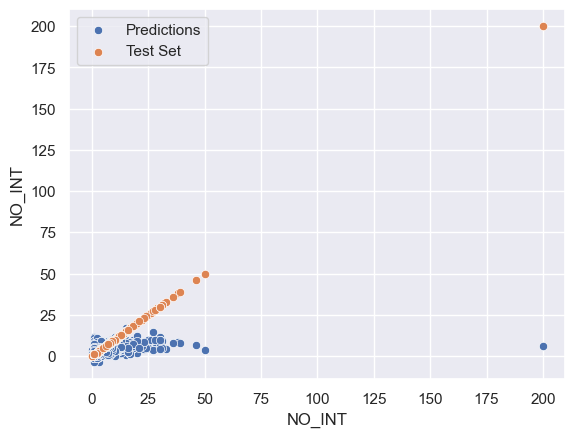

In [101]:
sns.scatterplot(x=y_test, y=pred, label='Predictions')
sns.scatterplot(x=y_test, y=y_test, label='Test Set')
plt.legend()